# Parte 2: Impacto de la Mitigación de Bias en Performance de Modelos
## Comparación de Logistic Regression y Random Forest
### Adult Dataset – AIF360 (Reweighing)

In [ ]:
import os
import urllib.request

# Crear la carpeta donde AIF360 busca los archivos
adult_path = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult'
os.makedirs(adult_path, exist_ok=True)

# Descargar los 3 archivos necesarios
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', os.path.join(adult_path, 'adult.data'))
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', os.path.join(adult_path, 'adult.test'))
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names', os.path.join(adult_path, 'adult.names'))

print("¡Archivos del Adult Dataset descargados correctamente!")

¡Archivos del Adult Dataset descargados correctamente!


In [ ]:
!pip install aif360
!pip install fairlearn
!pip install 'aif360[all]'
!pip install numba
!pip install scikit-learn

In [ ]:
# Celda 1: Importar todo lo necesario
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import pandas as pd

print("Todo importado correctamente")

Todo importado correctamente


In [ ]:
# Celda 2: Cargar dataset original (con features_to_drop=['race'] para evitar errores)
dataset_orig = AdultDataset(
    protected_attribute_names=['sex'],
    privileged_classes=[['Male']],
    features_to_drop=['race']
)

privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

In [ ]:
# Celda 3: Mitigar bias con Reweighing (como en la Parte 1)
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

In [ ]:
# Celda 4: Dividir en train/test (80/20) para ambos datasets
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.8], shuffle=True, seed=42)
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.8], shuffle=True, seed=42)

print("Datasets divididos: Train (80%), Test (20%)")

Datasets divididos: Train (80%), Test (20%)


In [ ]:
# Celda 5: Función para entrenar y evaluar modelo (Logistic Regression)
def train_and_evaluate(dataset_train, dataset_test, name):
    # Convertir a formato sklearn
    X_train = dataset_train.features
    y_train = dataset_train.labels.ravel()
    X_test = dataset_test.features
    y_test = dataset_test.labels.ravel()

    model = LogisticRegression(max_iter=2000, solver='saga', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Métricas de performance
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # Métricas de fairness en predicciones
    pred_dataset = dataset_test.copy()
    pred_dataset.labels = y_pred.reshape(-1, 1)

    metric = ClassificationMetric(
        dataset_test,
        pred_dataset,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    di = metric.disparate_impact()
    spd = metric.statistical_parity_difference()

    print(f"\n--- Resultados para {name} ---")
    print(f"Accuracy: {acc:.1%}")
    print(f"Precision: {prec:.1%}")
    print(f"Recall: {rec:.1%}")
    print(f"Disparate Impact (ideal ≈1.0): {di:.3f}")
    print(f"Statistical Parity Difference (ideal ≈0): {spd:.3f}")

In [ ]:
# Celda 6: Comparar ambos modelos
train_and_evaluate(dataset_orig_train, dataset_orig_test, "Datos Originales (Biased)")
train_and_evaluate(dataset_transf_train, dataset_transf_test, "Datos Mitigados (Reweighed)")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Resultados para Datos Originales (Biased) ---
Accuracy: 78.8%
Precision: 69.6%
Recall: 25.2%
Disparate Impact (ideal ≈1.0): 0.493
Statistical Parity Difference (ideal ≈0): -0.054

--- Resultados para Datos Mitigados (Reweighed) ---
Accuracy: 78.8%
Precision: 69.6%
Recall: 25.2%
Disparate Impact (ideal ≈1.0): 0.841
Statistical Parity Difference (ideal ≈0): -0.015


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


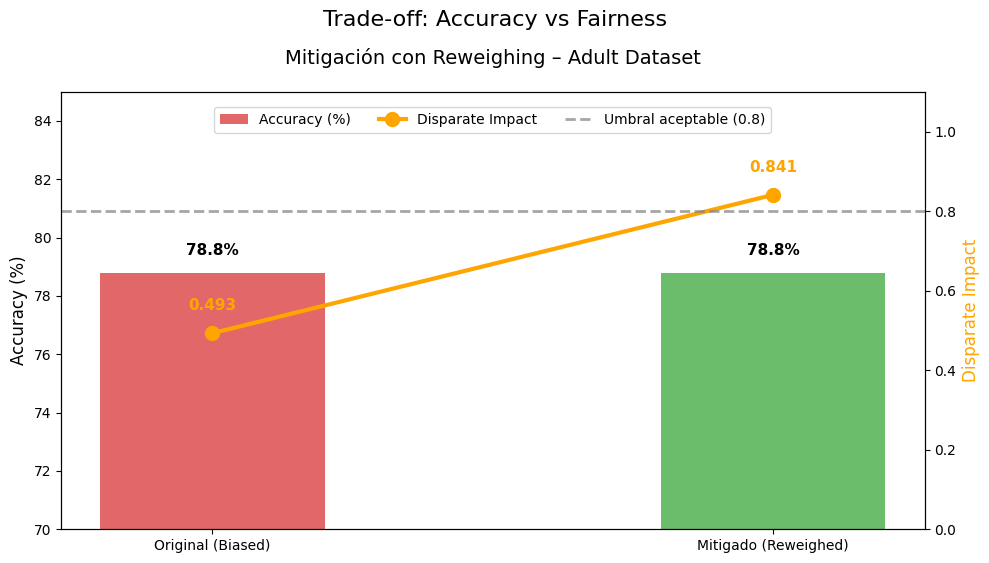

In [ ]:
import matplotlib.pyplot as plt

# Tus resultados reales
models = ['Original (Biased)', 'Mitigado (Reweighed)']
accuracy = [78.8, 78.8]
di = [0.493, 0.841]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras de Accuracy
bars = ax1.bar(models, accuracy, color=['#d62728', '#2ca02c'], alpha=0.7, width=0.4, label='Accuracy (%)')
ax1.set_ylabel('Accuracy (%)', color='black', fontsize=12)
ax1.set_ylim(70, 85)
ax1.tick_params(axis='y', labelcolor='black')

# Línea de Disparate Impact
ax2 = ax1.twinx()
line = ax2.plot(models, di, color='orange', marker='o', linewidth=3, markersize=10, label='Disparate Impact')
ax2.set_ylabel('Disparate Impact', color='orange', fontsize=12)
ax2.set_ylim(0, 1.1)
ax2.axhline(0.8, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Umbral aceptable (0.8)')

# Valores encima de barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Valores de DI subidos más arriba para evitar la leyenda
for i, val in enumerate(di):
    ax2.text(i, val + 0.05, f'{val:.3f}', ha='center', va='bottom', color='orange', fontweight='bold', fontsize=11)

# Título principal y subtítulo
plt.suptitle('Trade-off: Accuracy vs Fairness', fontsize=16, y=0.93)
plt.title('Mitigación con Reweighing – Adult Dataset', fontsize=14, pad=20)

# Leyenda bajada un poco más para dejar espacio al valor 0.841
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, frameon=True, fancybox=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier  # Añade este import arriba si no lo tienes

def train_and_evaluate(dataset_train, dataset_test, name):
    # Convertir a formato sklearn
    X_train = dataset_train.features
    y_train = dataset_train.labels.ravel()
    X_test = dataset_test.features
    y_test = dataset_test.labels.ravel()

    # Cambiamos a Random Forest
    model = RandomForestClassifier(
        n_estimators=200,      # 200 árboles (buen equilibrio precisión/velocidad)
        max_depth=None,
        random_state=42,
        n_jobs=-1              # Usa todos los núcleos disponibles
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Métricas de performance
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # Métricas de fairness
    pred_dataset = dataset_test.copy()
    pred_dataset.labels = y_pred.reshape(-1, 1)

    metric = ClassificationMetric(
        dataset_test,
        pred_dataset,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    di = metric.disparate_impact()
    spd = metric.statistical_parity_difference()

    print(f"\n--- Resultados para {name} (Random Forest) ---")
    print(f"Accuracy: {acc:.1%}")
    print(f"Precision: {prec:.1%}")
    print(f"Recall: {rec:.1%}")
    print(f"Disparate Impact: {di:.3f}")
    print(f"Statistical Parity Difference: {spd:.3f}")

In [ ]:
# Celda 6: Comparar ambos modelos
train_and_evaluate(dataset_orig_train, dataset_orig_test, "Datos Originales (Biased)")
train_and_evaluate(dataset_transf_train, dataset_transf_test, "Datos Mitigados (Reweighed)")


--- Resultados para Datos Originales (Biased) (Random Forest) ---
Accuracy: 84.6%
Precision: 71.8%
Recall: 62.2%
Disparate Impact: 0.327
Statistical Parity Difference: -0.184

--- Resultados para Datos Mitigados (Reweighed) (Random Forest) ---
Accuracy: 84.6%
Precision: 71.8%
Recall: 62.2%
Disparate Impact: 0.670
Statistical Parity Difference: -0.079


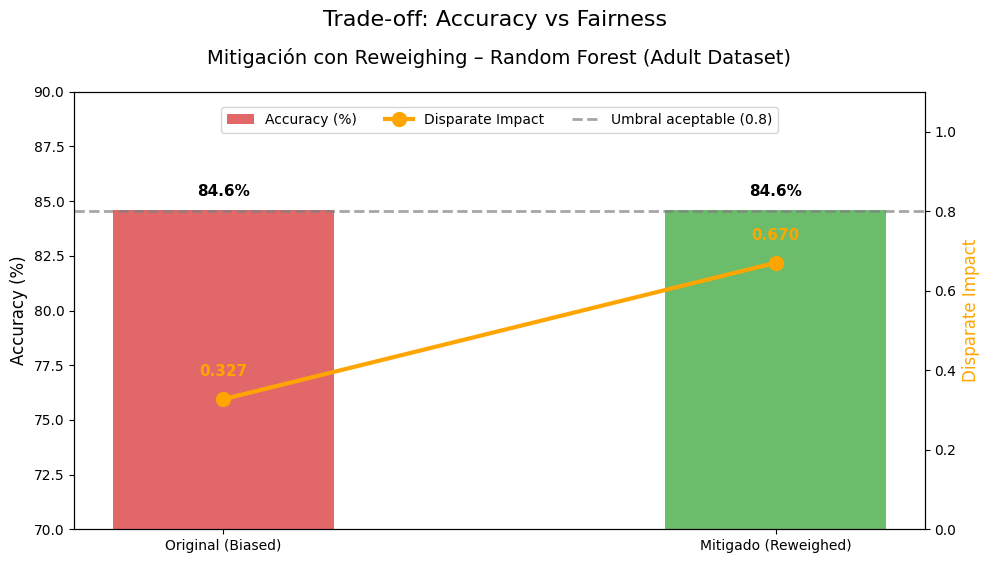

In [ ]:
import matplotlib.pyplot as plt

models = ['Original (Biased)', 'Mitigado (Reweighed)']
accuracy = [84.6, 84.6]
di = [0.327, 0.670]

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(models, accuracy, color=['#d62728', '#2ca02c'], alpha=0.7, width=0.4, label='Accuracy (%)')
ax1.set_ylabel('Accuracy (%)', color='black', fontsize=12)
ax1.set_ylim(70, 90)

ax2 = ax1.twinx()
line = ax2.plot(models, di, color='orange', marker='o', linewidth=3, markersize=10, label='Disparate Impact')
ax2.set_ylabel('Disparate Impact', color='orange', fontsize=12)
ax2.set_ylim(0, 1.1)
ax2.axhline(0.8, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Umbral aceptable (0.8)')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

for i, val in enumerate(di):
    ax2.text(i, val + 0.05, f'{val:.3f}', ha='center', va='bottom', color='orange', fontweight='bold', fontsize=11)

plt.suptitle('Trade-off: Accuracy vs Fairness', fontsize=16, y=0.93)
plt.title('Mitigación con Reweighing – Random Forest (Adult Dataset)', fontsize=14, pad=20)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Comparación Final: Logistic Regression vs Random Forest

| Modelo                  | Accuracy | Disparate Impact Original | Disparate Impact Mitigado | Mejora DI | Statistical Parity Diff Mitigado |
|-------------------------|----------|---------------------------|---------------------------|-----------|----------------------------------|
| Logistic Regression     | 78.8%   | 0.493                    | **0.841**                | +70%     | -0.015                          |
| Random Forest           | **84.6%** | 0.327                  | **0.670**                | +105%    | -0.079                          |

**Conclusiones clave**:
- Random Forest ofrece **+5.8 puntos de accuracy** y mejor recall.
- Reweighing mejora fairness en **ambos modelos** sin pérdida de accuracy.
- En modelos más potentes (Random Forest), el bias original es más fuerte, pero la mitigación sigue siendo efectiva.

### Conclusión
Random Forest supera a Logistic Regression en performance global (+5.8% accuracy, mucho mejor recall), pero muestra bias original más pronunciado.  
Reweighing mejora significativamente la fairness en ambos modelos **sin pérdida de accuracy**, demostrando que es posible equilibrar precisión y equidad.  
Este análisis ilustra un pipeline real de Responsible AI alineado con principios del EU AI Act.

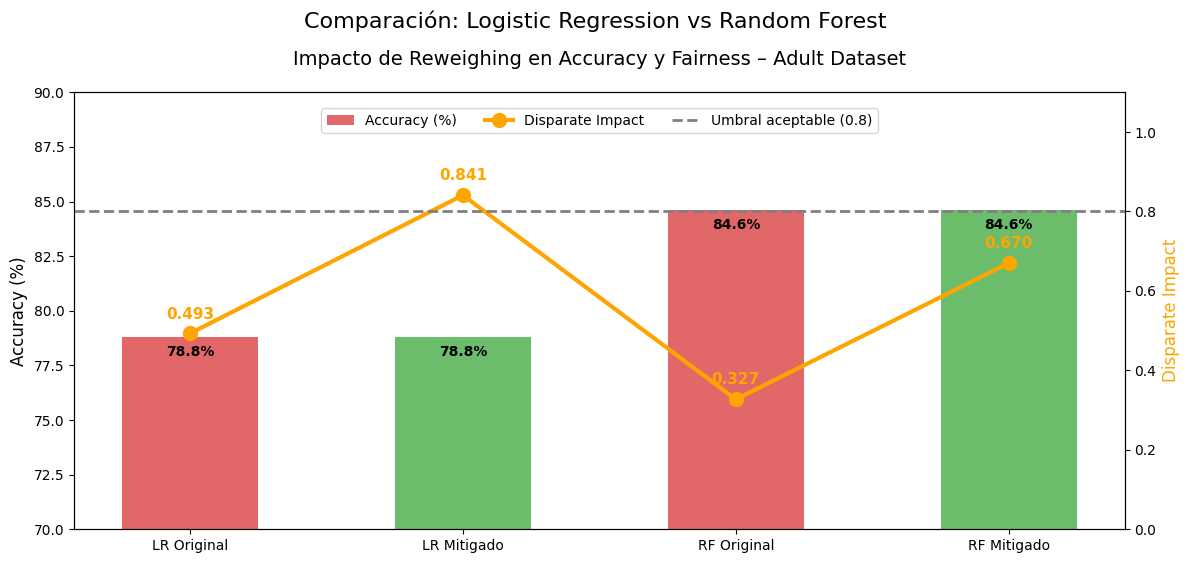

In [ ]:
import matplotlib.pyplot as plt

# Datos de los 4 casos
models = ['LR Original', 'LR Mitigado', 'RF Original', 'RF Mitigado']
accuracy = [78.8, 78.8, 84.6, 84.6]
di = [0.493, 0.841, 0.327, 0.670]
colors = ['#d62728', '#2ca02c', '#d62728', '#2ca02c']  # rojo para original, verde para mitigado

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras Accuracy
bars = ax1.bar(models, accuracy, color=colors, alpha=0.7, width=0.5, label='Accuracy (%)')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_ylim(70, 90)

# Línea Disparate Impact
ax2 = ax1.twinx()
line = ax2.plot(models, di, color='orange', marker='o', linewidth=3, markersize=10, label='Disparate Impact')
ax2.set_ylabel('Disparate Impact', color='orange', fontsize=12)
ax2.set_ylim(0, 1.1)
ax2.axhline(0.8, color='gray', linestyle='--', linewidth=2, label='Umbral aceptable (0.8)')

# Valores encima
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height - 1.0, f'{height}%', ha='center', va='bottom', fontweight='bold')

for i, val in enumerate(di):
    ax2.text(i, val + 0.03, f'{val:.3f}', ha='center', va='bottom', color='orange', fontweight='bold', fontsize=11)

plt.suptitle('Comparación: Logistic Regression vs Random Forest', fontsize=16, y=0.93)
plt.title('Impacto de Reweighing en Accuracy y Fairness – Adult Dataset', fontsize=14, pad=20)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()